## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Import Datasets

In [2]:
df = pd.read_csv('dataset/train-filtered.tsv', delimiter='\t')
df.head()

,ID,REVIEW,LABEL
0,0,"The waiter is not friendly, the person wears n...",1
1,1,"kak nya enak banget, pelayanan nya cepat tangg...",5
2,2,"Pelayanan sangat ramah, banyak promo nya",5
3,3,tempat nya nyaman dan bersih,5
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5


## Exploratory Data Analysis (EDA)

### Data information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      902 non-null    int64 
 1   REVIEW  902 non-null    object
 2   LABEL   902 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 21.3+ KB


The dataset used consists of 902 entries.

### Missing data

In [4]:
df.isnull().sum().sort_values(ascending=False)

ID        0
REVIEW    0
LABEL     0
dtype: int64

There is no null data.

### More data insights

In [5]:
number = df['LABEL'].value_counts().sort_values(ascending=False)
percent = df['LABEL'].value_counts().sort_values(ascending=False) / len(df) * 100

dataRating = pd.concat([number, percent], axis=1, keys=['Number of Rating','Percent'])
dataRating

,Number of Rating,Percent
LABEL,,
5,557,61.751663
1,157,17.405765
4,101,11.197339
3,46,5.099778
2,41,4.545455


<Axes: xlabel='LABEL'>

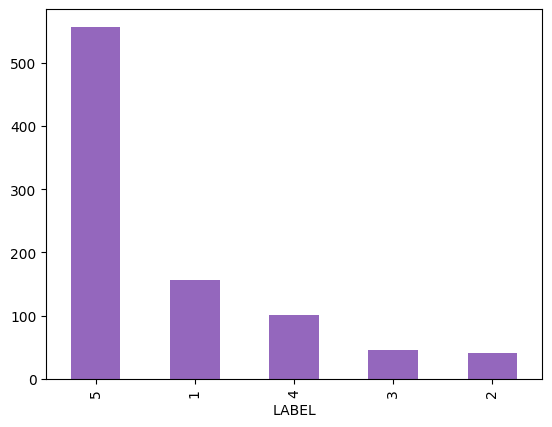

In [6]:
df['LABEL'].value_counts(dropna=False).plot(kind='bar', color='C4')

Insights:
1. Most of the reviews are positive. 557 reviews (61.75 %) are 5 stars.
2. There are 198 reviews (about 22 %) of reviewws are under 3 stars.

In [7]:
df['LENGTH'] = df['REVIEW'].apply(len)
df.head()

,ID,REVIEW,LABEL,LENGTH
0,0,"The waiter is not friendly, the person wears n...",1,64
1,1,"kak nya enak banget, pelayanan nya cepat tangg...",5,78
2,2,"Pelayanan sangat ramah, banyak promo nya",5,40
3,3,tempat nya nyaman dan bersih,5,28
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5,65


In [8]:
df[df['LENGTH'] == df['LENGTH'].max()]

,ID,REVIEW,LABEL,LENGTH
497,497,"mau me review tentang tukang parkir nya, seben...",3,1293


In [9]:
df[df['LENGTH'] == df['LENGTH'].min()]

,ID,REVIEW,LABEL,LENGTH
92,92,Santai,5,6


Insights:
1. The longest review sentences is 1222 characters long, which is very very long for a normal review.
2. The review is quite clean, there is no user bringing just punctuation (, or .) on a review sentence

## Text Cleaning

This text cleaning process includes:
- Upper case handling (so there is no difference in capital letters)
- look for root words in the Indonesian vocabulary (for example, 'membanggakan' == 'bannga' and 'kebanggan' == 'bangga')

In [10]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
negative_words = {
    'no', 'not', 'none', 'neither', 'never', 'nobody', 'nothing', 'nowhere',
    "doesn't", "isn't", "wasn't", "shouldn't", "won't", "can't", "couldn't",
    "don't", "haven't", "hasn't", "hadn't", "aren't", "weren't", "wouldn't",
    "daren't", "needn't", "didn't", 'without', 'against', 'negative', 'deny',
    'reject', 'refuse', 'decline', 'unhappy', 'sad', 'miserable', 'hopeless',
    'worthless', 'useless', 'futile', 'disagree', 'oppose', 'contrary',
    'contradict', 'disapprove', 'dissatisfied', 'objection', 'unsatisfactory',
    'unpleasant', 'regret', 'resent', 'lament', 'mourn', 'grieve', 'bemoan',
    'despise', 'loathe', 'detract', 'abhor', 'dread', 'fear', 'worry',
    'anxiety', 'sorrow', 'gloom', 'melancholy', 'dismay', 'disheartened',
    'despair', 'dislike', 'aversion', 'antipathy', 'hate', 'disdain',
    'shouldn', 'off', 'weren', 'hadn', 'all', 'couldn', 'mightn', 'don', 'why',
    'doesn', 'mustn', 'wouldn', 'nor', 'too', 'won', 'didn', 'hasn'
}

stop_words_eng = set(stopwords.words('english'))

In [13]:
kata_negatif = {
    'namun', 'tidak', 'karena', 'sementara', 'belum', 'telah', 'masih',
    'terhadap', 'secara', 'lain', 'begitu', 'mengapa', 'kenapa', 'daripada', 
    'maka', 'sebelum', 'sesudah', 'sedangkan', 'sementara', 'tetapi', 'kecuali', 
    'selain', 'tanpa', 'agak', 'tapi', 'nggak', 'seharusnya', 'sebetulnya', 'setidaknya', 
    'toh', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun'
}

stop_factory = StopWordRemoverFactory()
stop_words_indo = set(stop_factory.get_stop_words())

In [14]:
def convert_to_lower(text):
    return text.lower()

def stem_words(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords_indo(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in (stop_words_indo - kata_negatif)]
    return " ".join(filtered_tokens)

def remove_stopwords_eng(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in (stop_words_eng - negative_words)]
    return " ".join(filtered_tokens)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_unimportant_words(text):
    words_to_remove = ['yang', 'yg', 'nya', 'layan', 'tempat', 'makan', 'minum', 'dong', 'eh', 'deh', 'loh', 'kopken', 'excelso', 'gacoan', 'koi', 'gm', 'tp']
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in words_to_remove:
            removed.append(tokens[i])
    return " ".join(removed)

In [15]:
# Applying the function to the review text
df['PREPROCESS'] = df['REVIEW'].apply(convert_to_lower)
df['PREPROCESS'] = df['PREPROCESS'].apply(stem_words)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_numbers)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_punctuation)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_extra_white_spaces)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_stopwords_indo)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_stopwords_eng)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_unimportant_words)
df.head()

,ID,REVIEW,LABEL,LENGTH,PREPROCESS
0,0,"The waiter is not friendly, the person wears n...",1,64,waiter not friendly person wears night guard g...
1,1,"kak nya enak banget, pelayanan nya cepat tangg...",5,78,kak enak banget cepat tanggap pertama murah se...
2,2,"Pelayanan sangat ramah, banyak promo nya",5,40,sangat ramah banyak promo
3,3,tempat nya nyaman dan bersih,5,28,nyaman bersih
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5,65,cepat bagus coba durian coffee baru mantap


In [16]:
df['LENGTH_PRE'] = df['PREPROCESS'].apply(len)
df.head()

,ID,REVIEW,LABEL,LENGTH,PREPROCESS,LENGTH_PRE
0,0,"The waiter is not friendly, the person wears n...",1,64,waiter not friendly person wears night guard g...,52
1,1,"kak nya enak banget, pelayanan nya cepat tangg...",5,78,kak enak banget cepat tanggap pertama murah se...,50
2,2,"Pelayanan sangat ramah, banyak promo nya",5,40,sangat ramah banyak promo,25
3,3,tempat nya nyaman dan bersih,5,28,nyaman bersih,13
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5,65,cepat bagus coba durian coffee baru mantap,42


In [17]:
df[df['LENGTH_PRE'] == df['LENGTH_PRE'].min()]

,ID,REVIEW,LABEL,LENGTH,PREPROCESS,LENGTH_PRE
718,718,Oke juga tempat nya,5,19,oke,3


In [18]:
df = df.replace('', np.NaN)
df.isnull().sum()

ID            0
REVIEW        0
LABEL         0
LENGTH        0
PREPROCESS    0
LENGTH_PRE    0
dtype: int64

In [19]:
df = df.dropna()
df.isnull().sum()

ID            0
REVIEW        0
LABEL         0
LENGTH        0
PREPROCESS    0
LENGTH_PRE    0
dtype: int64

No null data even after the review data is preprocessed

array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>],
       [<Axes: title={'center': '5'}>, <Axes: >]], dtype=object)

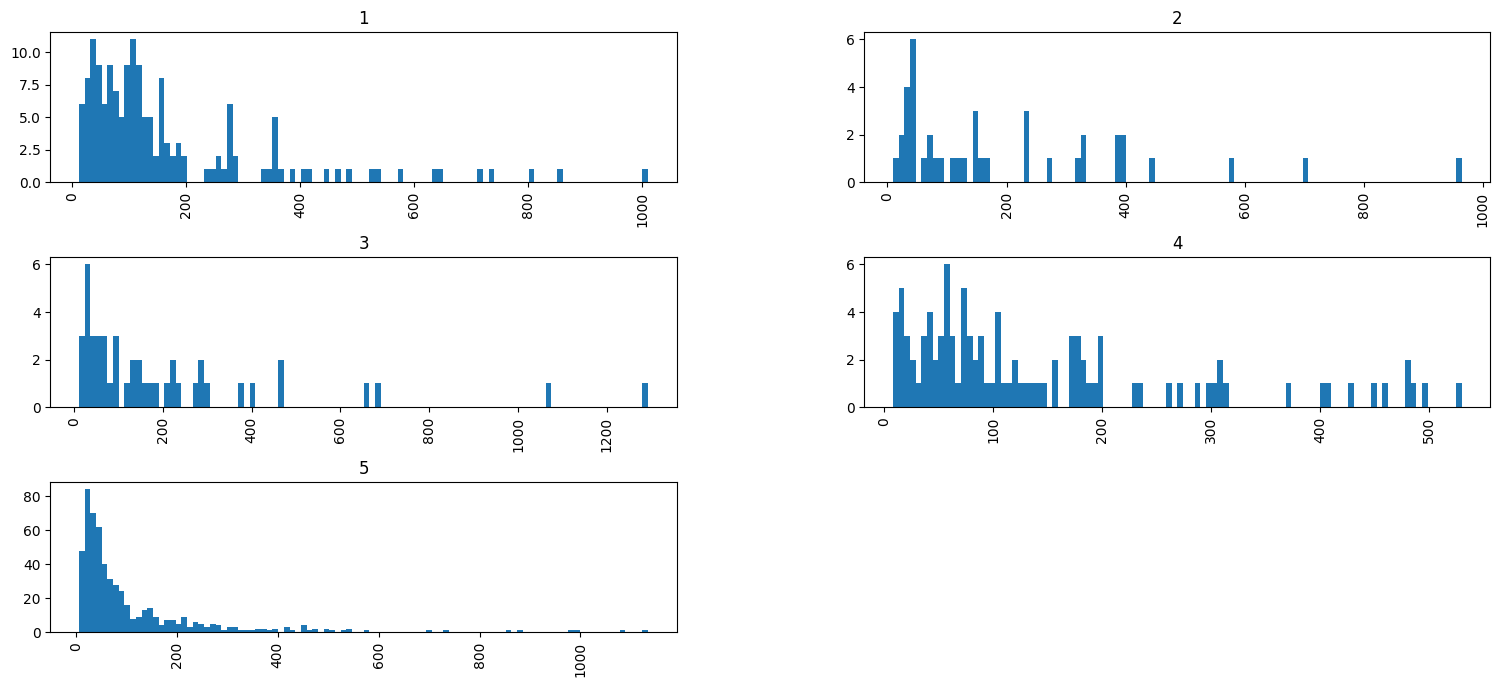

In [20]:
df.hist(column='LENGTH', by='LABEL', bins=100, figsize=(18,8))

There is no meaningful correlation between review data length and label.

In [21]:
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopword = STOPWORDS

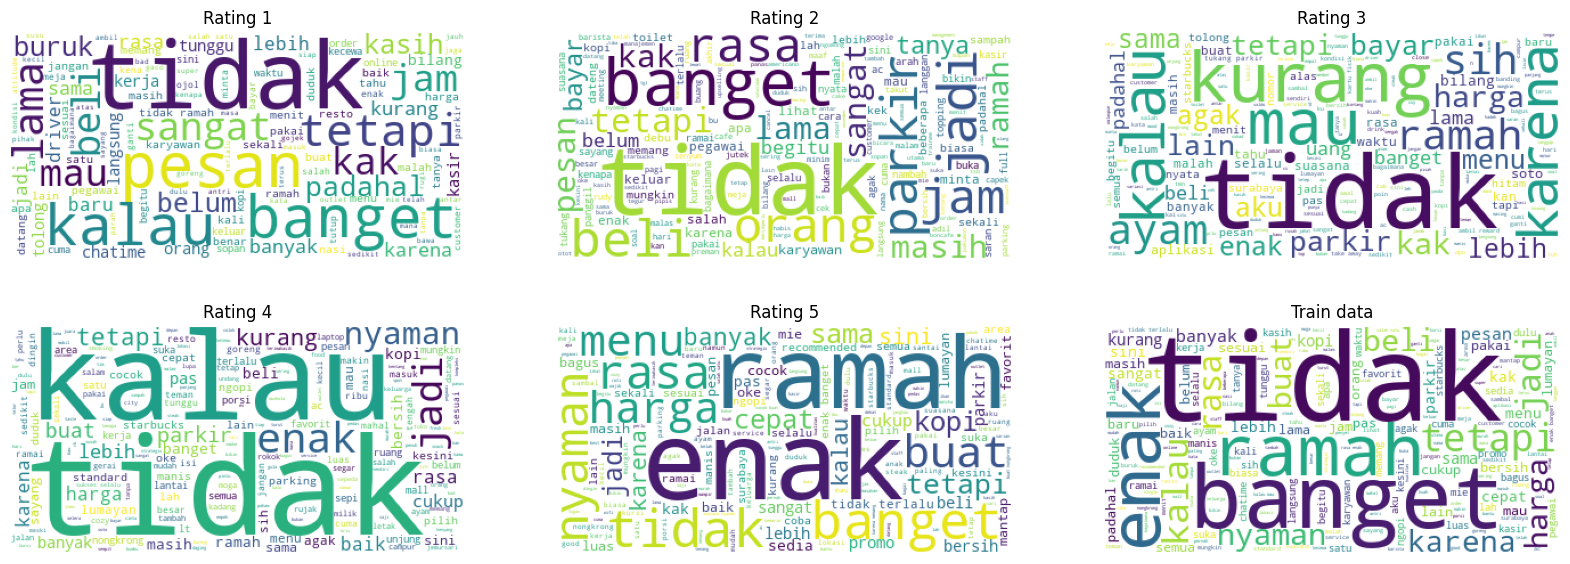

In [22]:
def wordclouds(a,b):
    all_data = ''.join(a['PREPROCESS'])
    wordcloud = WordCloud(stopwords = stopword, background_color="white").generate(all_data)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(b)
    
plt.figure(figsize=(20,7))
plt.subplot(231)
one = df[df['LABEL'] == 1]
wordclouds(one,'Rating 1')

plt.subplot(232)
two = df[df['LABEL'] == 2]
wordclouds(two,'Rating 2')

plt.subplot(233)
three = df[df['LABEL'] == 3]
wordclouds(three,'Rating 3')

plt.subplot(234)
four = df[df['LABEL'] == 4]
wordclouds(four,'Rating 4')

plt.subplot(235)
five = df[df['LABEL'] == 5]
wordclouds(five,'Rating 5')

plt.subplot(236)
wordclouds(df,'Train data')

In [23]:
## Checkpoints
df.to_csv('checkpoint/preprocessed-4.csv', index=False)

## Test Data Analysis

In [24]:
df_test = pd.read_csv('dataset/test-filtered.tsv', delimiter='\t')
df_test.head()

,ID,REVIEW
0,0,"LOCATION: Letak nya di perempatan jalan, di de..."
1,1,"Boleh lah sesekali kesini, makanan biasa saja ..."
2,2,tempat nya enak biarpun tidak luas. Suasana ny...
3,3,"depot bu Rudy antri, driver gojek kalau dapet ..."
4,4,saya sering banget makan di tempat ini ...teta...


In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      500 non-null    int64 
 1   REVIEW  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [26]:
df_test.isnull().sum().sort_values(ascending=False)

ID        0
REVIEW    0
dtype: int64

In [27]:
df_test['LENGTH'] = df_test['REVIEW'].apply(len)
df_test.head()

,ID,REVIEW,LENGTH
0,0,"LOCATION: Letak nya di perempatan jalan, di de...",757
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",178
2,2,tempat nya enak biarpun tidak luas. Suasana ny...,50
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",116
4,4,saya sering banget makan di tempat ini ...teta...,132


In [28]:
df_test[df_test['LENGTH'] == df_test['LENGTH'].max()]

,ID,REVIEW,LENGTH
444,444,TERUNTUK PEGAWAI CLEANING SERVICE LAKI LAKI BE...,2019


In [29]:
df_test[df_test['LENGTH'] == df_test['LENGTH'].min()]

,ID,REVIEW,LENGTH
387,387,The best,8


In [30]:
# Applying the function to the review text
df_test['PREPROCESS'] = df_test['REVIEW'].apply(convert_to_lower)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(stem_words)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_numbers)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_punctuation)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_extra_white_spaces)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_stopwords_indo)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_stopwords_eng)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_unimportant_words)
df_test.head()

,ID,REVIEW,LENGTH,PREPROCESS
0,0,"LOCATION: Letak nya di perempatan jalan, di de...",757,location letak empat jalan depan gereja lama g...
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",178,lah sekal kesini biasa bilang enak cukup lumay...
2,2,tempat nya enak biarpun tidak luas. Suasana ny...,50,enak biarpun tidak luas suasana nyaman
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",116,depot bu rudy antri driver gojek kalau dapet o...
4,4,saya sering banget makan di tempat ini ...teta...,132,sering banget tetapi lama lama sambal kok kura...


In [31]:
df_test['LENGTH_PRE'] = df_test['PREPROCESS'].apply(len)
df_test.head()

,ID,REVIEW,LENGTH,PREPROCESS,LENGTH_PRE
0,0,"LOCATION: Letak nya di perempatan jalan, di de...",757,location letak empat jalan depan gereja lama g...,515
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",178,lah sekal kesini biasa bilang enak cukup lumay...,119
2,2,tempat nya enak biarpun tidak luas. Suasana ny...,50,enak biarpun tidak luas suasana nyaman,38
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",116,depot bu rudy antri driver gojek kalau dapet o...,94
4,4,saya sering banget makan di tempat ini ...teta...,132,sering banget tetapi lama lama sambal kok kura...,81


In [32]:
df_test[df_test['LENGTH_PRE'] == df_test['LENGTH_PRE'].min()]

,ID,REVIEW,LENGTH,PREPROCESS,LENGTH_PRE
106,106,I ate them,10,ate,3
223,223,Pelayanan oke,13,oke,3


In [33]:
df_test = df_test.replace('', np.NaN)
df_test.isnull().sum()

ID            0
REVIEW        0
LENGTH        0
PREPROCESS    0
LENGTH_PRE    0
dtype: int64

In [34]:
df_test = df_test.dropna()
df_test.isnull().sum()

ID            0
REVIEW        0
LENGTH        0
PREPROCESS    0
LENGTH_PRE    0
dtype: int64

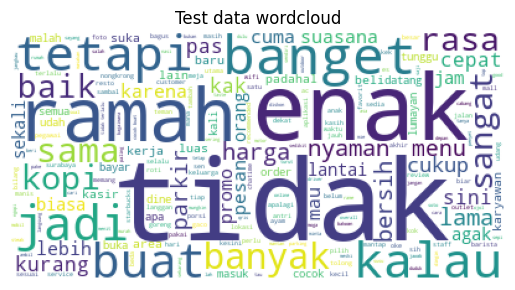

In [35]:
wordclouds(df_test,'Test data wordcloud')

In [36]:
## Checkpoints
df_test.to_csv('checkpoint/test-preprocessed-4.csv', index=False)

## Checkpoints

In [37]:
## Get the checkpoint file
df = pd.read_csv('checkpoint/preprocessed-4.csv')
df_test = pd.read_csv('checkpoint/test-preprocessed-4.csv')

## Data Splitting

In [38]:
from sklearn.model_selection import train_test_split

X = df['PREPROCESS']
Y = df['LABEL']
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42, test_size=0.285714)

In [39]:
x_train

148    baru tetapi duduk atur mau kasir bad lah janga...
499                        enak mantap rasa tidak kecewa
589    salah staff pakai polo shirt hitam logo securi...
275                 kopi jumbo mantap kopi nampol sekali
453    service buruk pernah aku experience semua tida...
                             ...                        
106             mie memang top utama bakso sangat lembut
270                  staff laki tidak ramah bad attitude
860    soto ayam lamongan kuah asa gurih daging ayam ...
435    kemarin belah nona manis lumayan ramai duduk t...
102        baru jam buka puasa nasi habis sedikit kecewa
Name: PREPROCESS, Length: 644, dtype: object

In [40]:
y_train.value_counts()

LABEL
5    390
1    115
4     70
3     38
2     31
Name: count, dtype: int64

In [41]:
x_val

70                                              too much
235                                          nyaman luas
430    oke segi oke spg ramah sopan pokok tidak nyese...
412    pegawai sombong tidak attitude rasa kopi encer...
39                                      cari angin tipis
                             ...                        
863                       starbucks expect kopi lah enak
814    really eat worth paying doubt choose something...
660                              besar nyaman gausa ragu
212     enak banget trus suasana nyaman lagu enak dengar
79     karyawan lama lambat parah lama banget tidak r...
Name: PREPROCESS, Length: 258, dtype: object

In [42]:
y_val.value_counts()

LABEL
5    167
1     42
4     31
2     10
3      8
Name: count, dtype: int64

## Data Modeling
Before the data is entered into the model, the text data must first be converted into numeric using the word weighting method (Count Vectorizer, TFIDF). To make coding efficient, we will use a pipeline.

because this dataset is a Supervised Learning dataset, it means you can use Regression or Classification

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [44]:
def evaluation(x, y):
    print(classification_report(x, y, zero_division=1))
    cm = confusion_matrix(x, y)
    sb.heatmap(pd.DataFrame(cm),annot=True, cmap="BuPu" ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Pipelines

In [45]:
pipeline_Random = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
])

pipeline_Logistic = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', LogisticRegression()),
])

pipeline_SVC2 = Pipeline([
    ('cv', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', SVC()),
])

pipeline_Bayes = Pipeline([
    ('cv', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [46]:
pipeline_Random.fit(x_train, y_train)
pipeline_Logistic.fit(x_train, y_train)
pipeline_SVC2.fit(x_train, y_train)
pipeline_Bayes.fit(x_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

## Evaluation Matrix 1 - Data Training

              precision    recall  f1-score   support

           1       0.57      0.92      0.70        71
           2       0.00      1.00      0.00         0
           3       0.03      1.00      0.05         1
           4       0.00      1.00      0.00         0
           5       1.00      0.68      0.81       572

    accuracy                           0.71       644
   macro avg       0.32      0.92      0.31       644
weighted avg       0.95      0.71      0.80       644



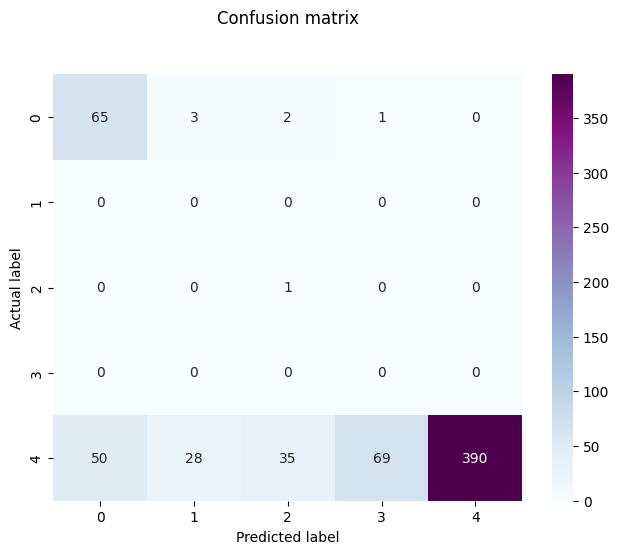

In [47]:
y_pred_bayes_train = pipeline_Bayes.predict(x_train)
evaluation(y_pred_bayes_train, y_train)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        38
           4       0.96      1.00      0.98        67
           5       1.00      0.99      1.00       393

    accuracy                           1.00       644
   macro avg       0.99      1.00      0.99       644
weighted avg       1.00      1.00      1.00       644



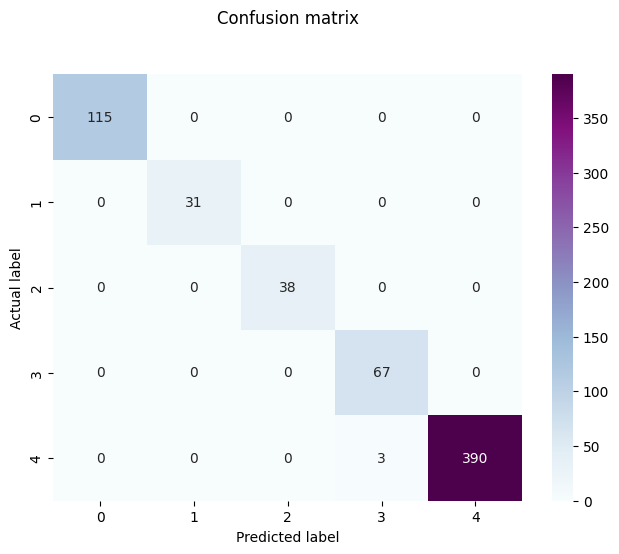

In [48]:
y_pred_rf_train = pipeline_Random.predict(x_train)
evaluation(y_pred_rf_train, y_train)

              precision    recall  f1-score   support

           1       0.81      0.84      0.82       111
           2       0.00      1.00      0.00         0
           3       0.03      1.00      0.05         1
           4       0.14      1.00      0.25        10
           5       1.00      0.75      0.85       522

    accuracy                           0.77       644
   macro avg       0.40      0.92      0.40       644
weighted avg       0.95      0.77      0.84       644



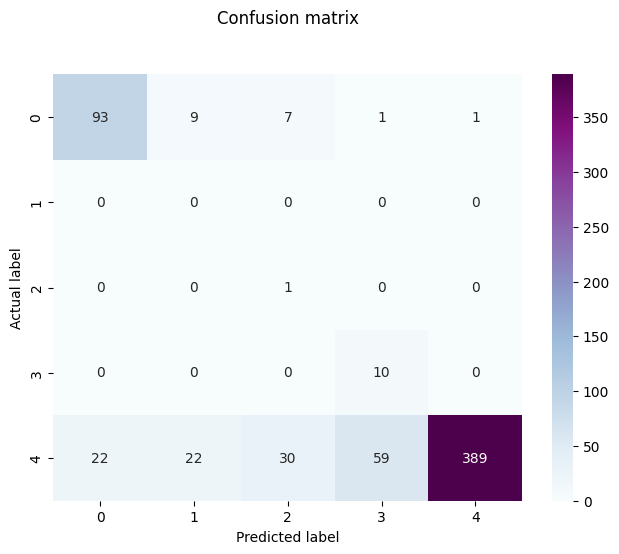

In [49]:
y_pred_lr_train = pipeline_Logistic.predict(x_train)
evaluation(y_pred_lr_train, y_train)

              precision    recall  f1-score   support

           1       0.98      0.95      0.97       119
           2       0.32      1.00      0.49        10
           3       0.55      1.00      0.71        21
           4       0.67      1.00      0.80        47
           5       1.00      0.87      0.93       447

    accuracy                           0.90       644
   macro avg       0.71      0.96      0.78       644
weighted avg       0.95      0.90      0.91       644



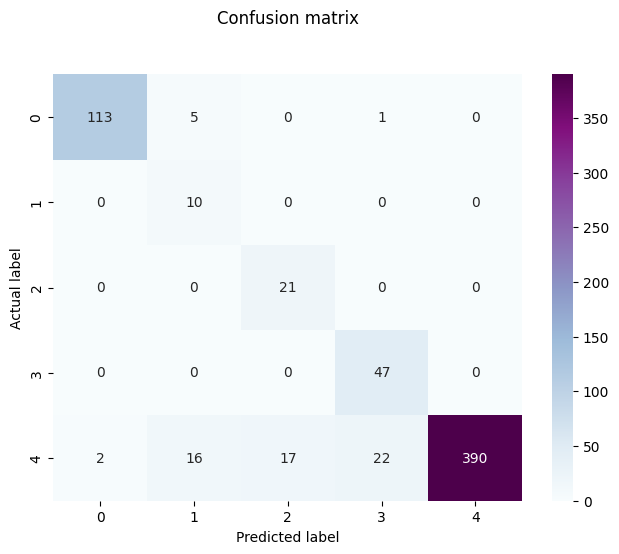

In [50]:
y_pred_svc_train = pipeline_SVC2.predict(x_train)
evaluation(y_pred_svc_train, y_train)

## Evaluation Matrix 2 - Data Validation

### Naive-Bayes

              precision    recall  f1-score   support

           1       0.24      0.83      0.37        12
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       1.00      0.68      0.81       246

    accuracy                           0.69       258
   macro avg       0.25      0.90      0.24       258
weighted avg       0.96      0.69      0.79       258



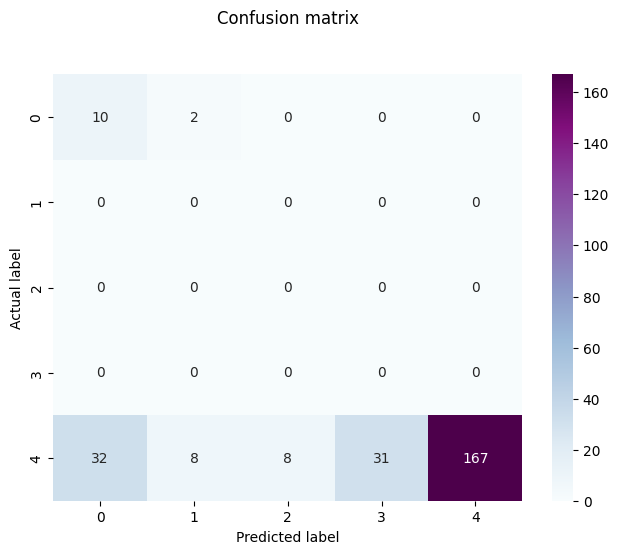

In [51]:
y_pred_bayes = pipeline_Bayes.predict(x_val)
evaluation(y_pred_bayes, y_val)

### Random Forest

              precision    recall  f1-score   support

           1       0.57      0.69      0.62        35
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.03      0.50      0.06         2
           5       0.98      0.74      0.84       221

    accuracy                           0.73       258
   macro avg       0.32      0.78      0.30       258
weighted avg       0.91      0.73      0.80       258



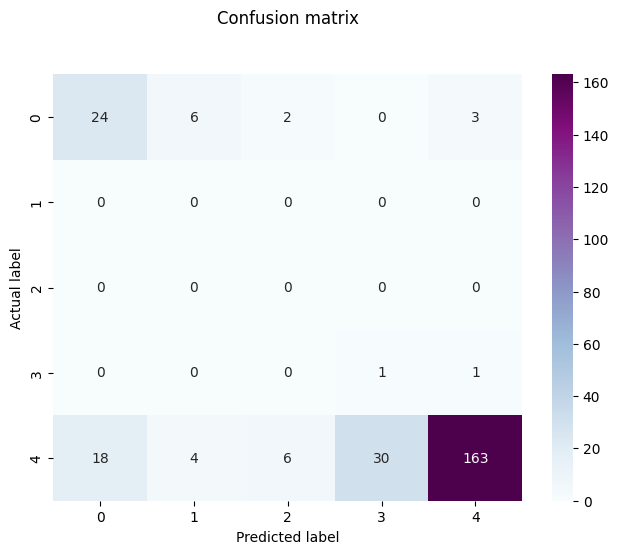

In [52]:
y_pred_rf = pipeline_Random.predict(x_val)
evaluation(y_pred_rf, y_val)

### Logictic Regression

              precision    recall  f1-score   support

           1       0.52      0.69      0.59        32
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.97      0.72      0.83       224

    accuracy                           0.71       258
   macro avg       0.30      0.68      0.28       258
weighted avg       0.91      0.71      0.79       258



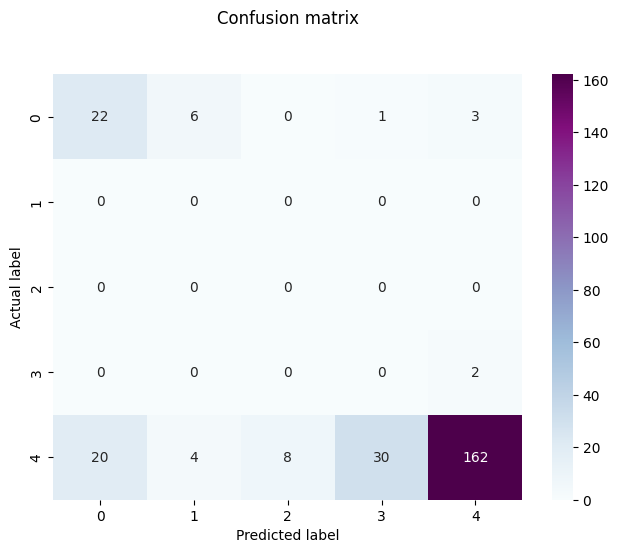

In [53]:
y_pred_lr = pipeline_Logistic.predict(x_val)
evaluation(y_pred_lr, y_val)

### Support Vector Classification (SVC)

              precision    recall  f1-score   support

           1       0.40      0.61      0.49        28
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.98      0.72      0.83       229

    accuracy                           0.70       258
   macro avg       0.28      0.66      0.26       258
weighted avg       0.92      0.70      0.79       258



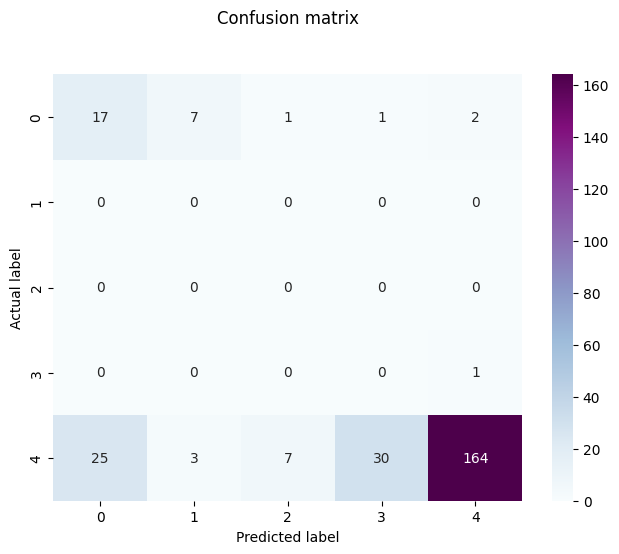

In [54]:
y_pred_svc = pipeline_SVC2.predict(x_val)
evaluation(y_pred_svc, y_val)

Looking at the three models above, the average accuracy is almost the same as SVC (70 %), Random Forest (71 %), Logistic regression (72 %), but for all three the recall value for rating 2 = 0.0

## Hyperparameter Tuning

In [55]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Random Forest

In [56]:
# Number of trees in random forest
n_estimators = np.arange(100, 400, 100)
# Maximum number of levels in tree
max_depth = [10, 20, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf' : min_samples_leaf,
              }
BestParamsforest= RandomizedSearchCV(pipeline_Random, random_grid, cv=5, n_jobs=-1, verbose=1)
BestParamsforest.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [10, 20, 30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': array([100, 200, 300])},
                   verbose=1)

              precision    recall  f1-score   support

           1       0.74      0.82      0.78       104
           2       0.10      1.00      0.18         3
           3       0.18      1.00      0.31         7
           4       0.13      1.00      0.23         9
           5       1.00      0.75      0.85       521

    accuracy                           0.77       644
   macro avg       0.43      0.91      0.47       644
weighted avg       0.93      0.77      0.82       644



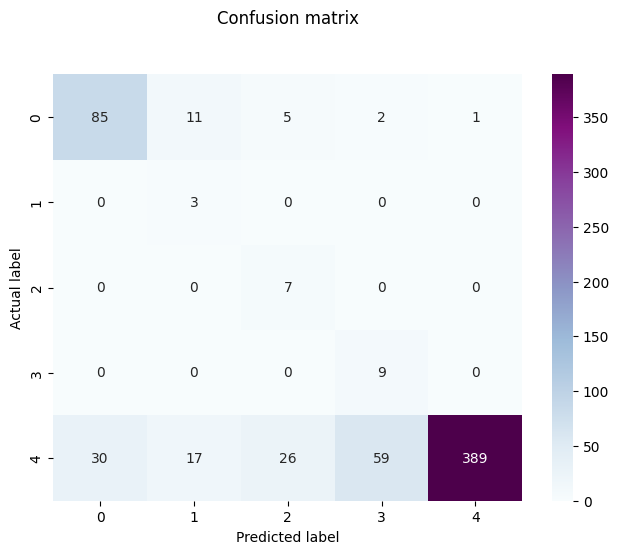

In [57]:
y_pred_rf_max_train = BestParamsforest.predict(x_train)
evaluation(y_pred_rf_max_train, y_train)

              precision    recall  f1-score   support

           1       0.38      0.62      0.47        26
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.99      0.71      0.83       232

    accuracy                           0.70       258
   macro avg       0.27      0.87      0.26       258
weighted avg       0.93      0.70      0.79       258



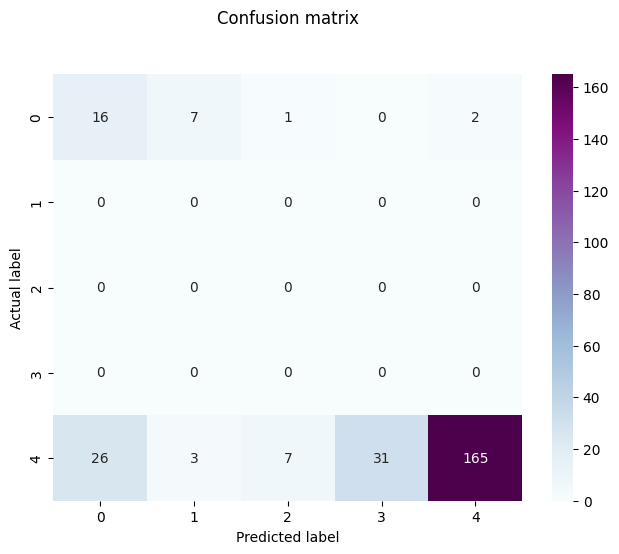

In [58]:
y_pred_rf_max = BestParamsforest.predict(x_val)
evaluation(y_pred_rf_max, y_val)

### Support Vector Classification (SVC)

In [59]:
random_grid = {'classifier__C': [0.1, 1, 10, 100, 1000],
               'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
BestParamsSVC = RandomizedSearchCV(pipeline_SVC2, random_grid, cv=5, n_jobs= -1, verbose=1)
BestParamsSVC.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('classifier', SVC())]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10, 100,
                                                          1000],
                                        'classifier__gamma': [1, 0.1, 0.01,
                                                              0.001, 0.0001],
                                        'classifier__kernel': ['linear', 'poly',
                                                               'rbf',
                                                               'sigmoid']},
                   verbose=1)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        38
           4       0.96      1.00      0.98        67
           5       1.00      0.99      1.00       393

    accuracy                           1.00       644
   macro avg       0.99      1.00      0.99       644
weighted avg       1.00      1.00      1.00       644



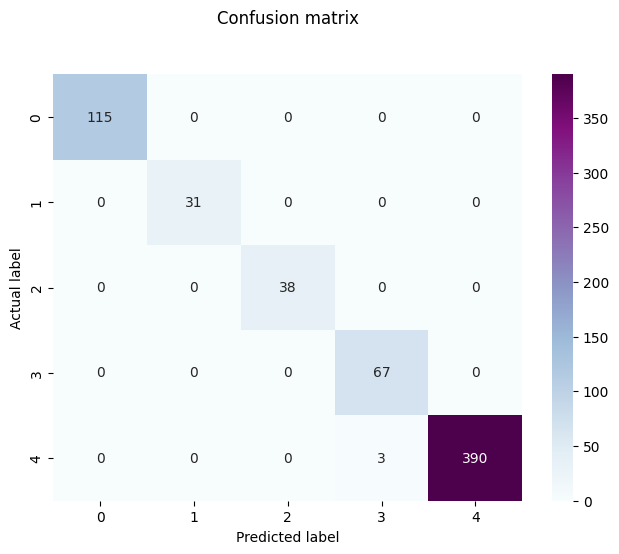

In [60]:
y_pred_svc_max_train = BestParamsSVC.predict(x_train)
evaluation(y_pred_svc_max_train, y_train)

              precision    recall  f1-score   support

           1       0.71      0.64      0.67        47
           2       0.00      0.00      0.00         4
           3       0.12      0.11      0.12         9
           4       0.13      0.19      0.15        21
           5       0.86      0.81      0.84       177

    accuracy                           0.69       258
   macro avg       0.37      0.35      0.36       258
weighted avg       0.74      0.69      0.71       258



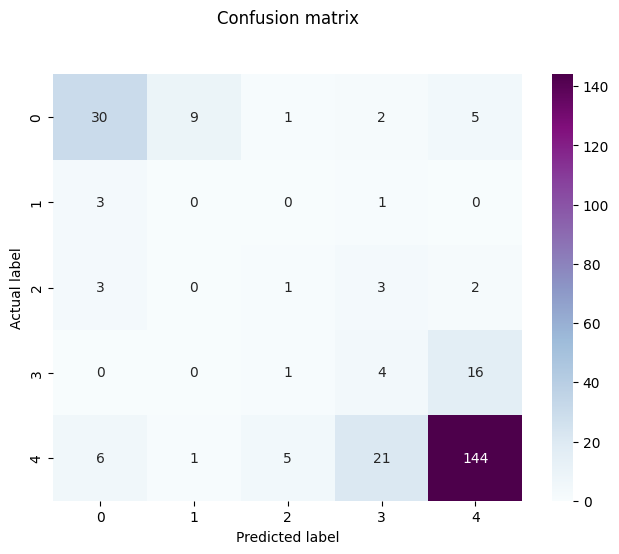

In [61]:
y_pred_svc_max = BestParamsSVC.predict(x_val)
evaluation(y_pred_svc_max, y_val)

## Final Processing

In [62]:
df_test['LABEL'] = BestParamsSVC.predict(df_test['PREPROCESS'])
df_test

,ID,REVIEW,LENGTH,PREPROCESS,LENGTH_PRE,LABEL
0,0,"LOCATION: Letak nya di perempatan jalan, di de...",757,location letak empat jalan depan gereja lama g...,515,5
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",178,lah sekal kesini biasa bilang enak cukup lumay...,119,5
2,2,tempat nya enak biarpun tidak luas. Suasana ny...,50,enak biarpun tidak luas suasana nyaman,38,1
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",116,depot bu rudy antri driver gojek kalau dapet o...,94,5
4,4,saya sering banget makan di tempat ini ...teta...,132,sering banget tetapi lama lama sambal kok kura...,81,1
...,...,...,...,...,...,...
495,495,"ini mengapa buruk, titik lokasimu kok di jalan...",57,mengapa buruk titik lokasi kok jalan ahmad yani,47,5
496,496,"tempat nya enak, deket pintu keluar. kalau men...",87,enak deket pintu keluar kalau menu sama umum enak,49,5
497,497,pelayan nya agak menyebalkan sih,32,agak sebal sih,14,4
498,498,"Makanan nya untuk saya kurang cocok, hanya pis...",116,kurang cocok pisang goreng madu enak tidak beb...,72,1


In [63]:
# Create result dataframe
result_df = pd.DataFrame({'ID': df_test['ID'], 'LABEL': df_test['LABEL']})

# Menyimpan dataframe dalam csv
result_df.to_csv('result/final-svc-best-sofar-2.csv', index=False)

## Recurrent neural network (RNN) - LSTM

In [64]:
## Get the checkpoint file
df = pd.read_csv('checkpoint/preprocessed-4.csv')
df.head()

,ID,REVIEW,LABEL,LENGTH,PREPROCESS,LENGTH_PRE
0,0,"The waiter is not friendly, the person wears n...",1,64,waiter not friendly person wears night guard g...,52
1,1,"kak nya enak banget, pelayanan nya cepat tangg...",5,78,kak enak banget cepat tanggap pertama murah se...,50
2,2,"Pelayanan sangat ramah, banyak promo nya",5,40,sangat ramah banyak promo,25
3,3,tempat nya nyaman dan bersih,5,28,nyaman bersih,13
4,4,"Pelayanan cepat dan bagus, coba Durian Coffee ...",5,65,cepat bagus coba durian coffee baru mantap,42


In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

tokenizer = Tokenizer(oov_token="unk")
tokenizer.fit_on_texts(df['PREPROCESS'].tolist())

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(df['PREPROCESS'].tolist(), df['LABEL'].tolist(), random_state=42, test_size=0.285714)

In [67]:
from collections import Counter

def count_unique_and_frequencies(lst):
    # Use Counter to count frequencies
    freq_counter = Counter(lst)
    
    # Print unique numbers and their frequencies
    for num, freq in freq_counter.items():
        print(f"Number {num} has frequency {freq}")
        
count_unique_and_frequencies(y_train)

Number 1 has frequency 115
Number 5 has frequency 390
Number 2 has frequency 31
Number 3 has frequency 38
Number 4 has frequency 70


In [68]:
count_unique_and_frequencies(y_valid)

Number 4 has frequency 31
Number 5 has frequency 167
Number 1 has frequency 42
Number 2 has frequency 10
Number 3 has frequency 8


In [69]:
sequences = tokenizer.texts_to_sequences(df['PREPROCESS'].tolist())
max_length = max([len(seq) for seq in sequences])

# Convert texts to sequences
x_train_seq = tokenizer.texts_to_sequences(X_train)
x_valid_seq = tokenizer.texts_to_sequences(X_valid)

# Padding sequences
x_train_pad = pad_sequences(x_train_seq, padding='post', maxlen=max_length)
x_valid_pad = pad_sequences(x_valid_seq, padding='post', maxlen=max_length)

In [70]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_pad, np.asarray(tf.keras.utils.to_categorical(y_train))))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid_pad, np.asarray(tf.keras.utils.to_categorical(y_valid))))

In [71]:
from tensorflow.keras import regularizers
embedding_dim = 64
vocab_size = len(tokenizer.word_index) + 1

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_regularizer=regularizers.l2(0.0005)))                                     
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=32, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])


In [72]:
epochs = 5
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(100).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/5


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


: 

In [ ]:
# Get the test checkpoint
df_test = pd.read_csv('checkpoint/test-preprocessed-4.csv')
df_test.head()

In [ ]:
# Convert texts to sequences
x_test_seq = tokenizer.texts_to_sequences(df_test['PREPROCESS'].tolist())

# Padding sequences
x_test_pad = pad_sequences(x_test_seq, padding='post', maxlen=max_length)

In [ ]:
predictions = model.predict(x_test_pad)
predictions_res = predictions.argmax(axis=1)
print(predictions_res)

In [ ]:
predictions_results = pd.DataFrame(df_test['REVIEW'], columns=['REVIEW'])
predictions_results2 = pd.DataFrame(predictions_res, columns=['LABEL'])

predictions_results = pd.concat([predictions_results, predictions_results2], axis=1)
predictions_results

In [ ]:
# Menyimpan dataframe dalam csv
predictions_results.to_csv('result/final-lstm-sofar.csv', index=False)